gofasta vs amanual mutation calling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO


In [30]:
pd.set_option('display.max_rows', 200)

In [55]:
hu1_gf_dir = '/home/eleanor124/projects/bjorn_rep/output/Hu1/gf_Hu1/'
hu1_mm_dir = '/home/eleanor124/projects/bjorn_rep/output/Hu1/mm/'
ba1_gf_dir = '/home/eleanor124/projects/bjorn_rep/output/Hu1/gf_BA1/'
ba2_gf_dir = '/home/eleanor124/projects/bjorn_rep/output/Hu1/gf_BA2/'


pb2_old_dir = '/home/eleanor124/projects/bjorn_rep/data/PB2-DMS/'
pb2_gf_dir = '/home/eleanor124/projects/bjorn_rep/output/PB2/gf_PP/'
pb2_mm_dir = '/home/eleanor124/projects/bjorn_rep/output/PB2/mm/'

cy_gf_dir = '/home/eleanor124/projects/bjorn_rep/output/PB2/gf_CY/'
cy_mm_dir = '/home/eleanor124/projects/bjorn_rep/output/PB2/mm/'


In [3]:
ambiguous_nuc = ['R', 'Y', 'W', 'S', 'K', 'M', 'B', 'D', 'H', 'V', 'N']

In [62]:
def process(path, common_set):
    df = pd.read_csv(path, sep="\t")
    df = (
        df[["sra", "region", "pos", "ref", "alt"]]
        .drop_duplicates()
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
    )
    if common_set:
        df_filtered = df.copy()
        df_filtered = df_filtered.loc[df_filtered["sra"].isin(common_set), :]

        return df, df_filtered
    else:
        return df, None


In [5]:
def corr_plt(standard, manual, title):

    standard_grp = (
        standard[~standard["alt"].str.upper().isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_standard")
    )

    manual_grp = (
        manual[~manual["alt"].str.upper().isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_manual")
    )
    
    merged2 = pd.merge(standard_grp, manual_grp, on='sra', how="outer").fillna(0)

    plt.scatter(merged2['pos_count_manual'], merged2['pos_count_standard'], color='lightblue')
    minv = min(merged2['pos_count_manual'])
    maxv = max(merged2['pos_count_manual'])
    
    plt.plot([minv, maxv], [minv, maxv], 'r--', label='y = x')
    plt.legend(loc='upper right')
    plt.xlabel("pos count - our mutation calling")
    plt.ylabel("pos count - standard")
    plt.title(f"Number of mutations in each position, excluding ambiguous nuc for ALT - {title}")
    plt.tight_layout()
    plt.show()

    return merged2[merged2['pos_count_standard'] != merged2['pos_count_manual']]


In [47]:
def get_common_seqs(fa1, fa2):
    seq1 = {rec.id: str(rec.seq).upper() for rec in SeqIO.parse(fa1, "fasta")}
    seq2 = {rec.id: str(rec.seq).upper() for rec in SeqIO.parse(fa2, "fasta")}
    common_ids = set(seq1.keys()) & set(seq2.keys())
    
    return [i for i in common_ids if seq1[i] == seq2[i]]

## Hu1-BA

100.0 % sequences are identical.


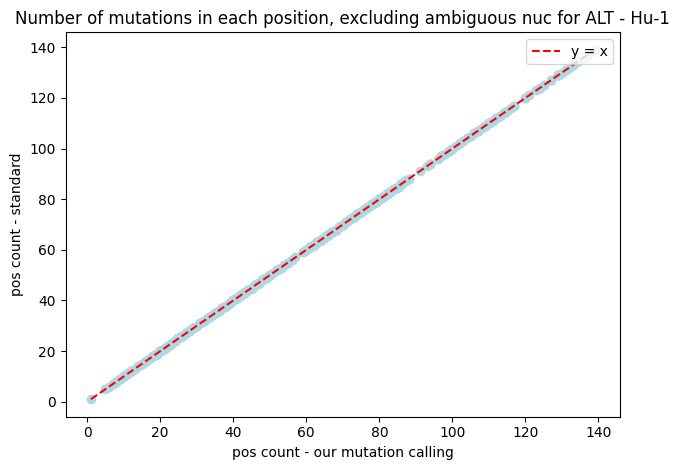

,sra,pos_count_standard,pos_count_manual,gap


In [ ]:
common_set = get_common_seqs(hu1_gf_dir+"alignment.fasta", hu1_mm_dir+"alignment.fasta")

hu1_gf, hu1_gf_filtered = process(hu1_gf_dir+"mutations.tsv", common_set)
hu1_mm, hu1_mm_filtered = process(hu1_mm_dir+"mutations.tsv", common_set)

print(round(len(hu1_mm_filtered)/len(hu1_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt(hu1_gf_filtered, hu1_mm_filtered, "Hu-1")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)

In [34]:
tmp1 = (hu1_gf[~hu1_gf["alt"].isin(ambiguous_nuc)]
        .drop_duplicates(subset=["sra", "pos", "ref", "alt"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)
tmp2 = (hu1_mm[~hu1_mm["alt"].isin(ambiguous_nuc)]
        .drop_duplicates(subset=["sra", "pos", "ref", "alt"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)

tmp1.equals(tmp2)

True

93.0 % sequences in the alignment files are identical.


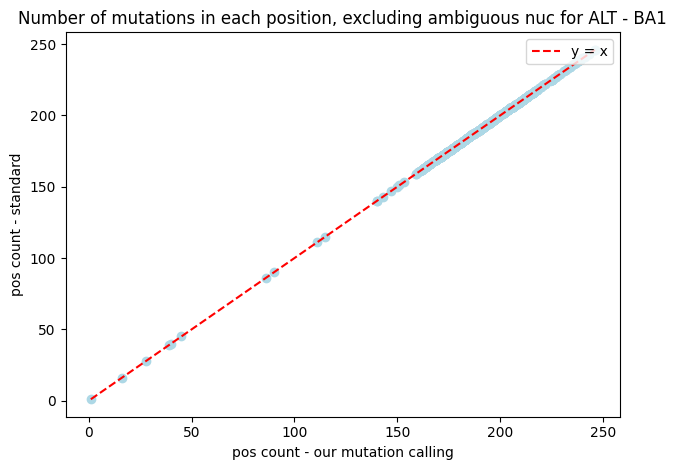

,sra,pos_count_standard,pos_count_manual,gap


In [48]:
common_set = get_common_seqs(ba1_gf_dir+"alignment.fasta", hu1_mm_dir+"alignment.fasta")

ba1_gf, ba1_gf_filtered = process(ba1_gf_dir+"mutations.tsv", common_set)
ba1_mm, ba1_mm_filtered = process(hu1_mm_dir+"NC_045512.2_BA.1_mutations.tsv", common_set)

print(round(len(ba1_mm_filtered)/len(ba1_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt(ba1_gf_filtered, ba1_mm_filtered, "BA1")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)

In [ ]:
tmp1 = ba1_gf[(ba1_gf["sra"] == "hCoV-19/USA/CA-SEARCH-140651/2024") & (~ba1_gf["alt"].isin(ambiguous_nuc))]
tmp2 = ba1_mm[(ba1_mm["sra"] == 'hCoV-19/USA/CA-SEARCH-140651/2024') & (~ba1_mm["alt"].isin(ambiguous_nuc))]
m = pd.merge(tmp1, tmp2, how="outer", on=["pos"], indicator=True)
m[m["_merge"] != "both"]

In [ ]:
tmp1 = ba1_gf[(ba1_gf["sra"] == "hCoV-19/USA/CA-SEARCH-233687/2024") & (~ba1_gf["alt"].isin(ambiguous_nuc))]
tmp2 = ba1_mm[(ba1_mm["sra"] == 'hCoV-19/USA/CA-SEARCH-233687/2024') & (~ba1_mm["alt"].isin(ambiguous_nuc))]
m = pd.merge(tmp1, tmp2, how="outer", on=["pos"], indicator=True)
m[m["_merge"] != "both"]

100.0 % sequences in the alignment files are identical.


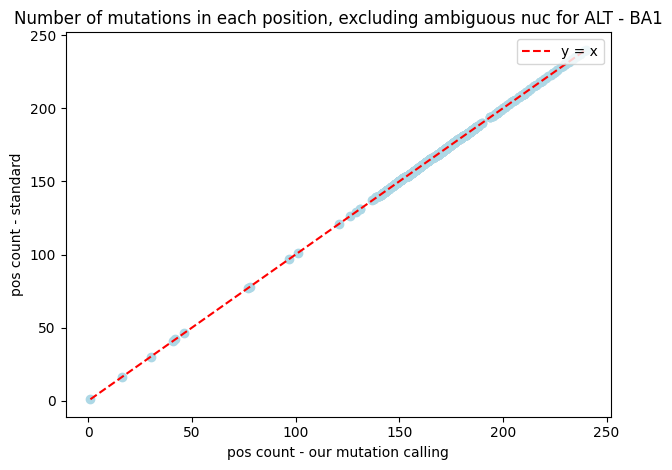

,sra,pos_count_standard,pos_count_manual,gap


In [ ]:
common_set = get_common_seqs(ba2_gf_dir+"alignment.fasta", hu1_mm_dir+"alignment.fasta")

ba2_gf, ba2_gf_filtered = process(ba2_gf_dir+"mutations.tsv", common_set)
ba2_mm, ba2_mm_filtered = process(hu1_mm_dir+"NC_045512.2_BA.2_mutations.tsv", common_set)

print(round(len(ba2_mm_filtered)/len(ba2_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt(ba2_gf_filtered, ba2_mm_filtered, "BA2")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)


In [ ]:
tmp1 = ba1_mm.loc[ba1_mm["sra"] == "hCoV-19/Iraq/KR-SEARCH-119907/2021", ]
tmp2 = ba1_gf.loc[ba1_gf["sra"] == "hCoV-19/Iraq/KR-SEARCH-119907/2021", ]
m = pd.merge(tmp1, tmp2, on=["sra", "pos"], how="outer", indicator=True)
m[(m["_merge"]== "left_only")&(~m["alt_x"].isin(ambiguous_nuc))]

In [ ]:
tmp1 = ba1_gf.loc[ba1_gf["sra"] == "hCoV-19/Iraq/KR-SEARCH-118872/2021", ]
tmp2 = ba1_mm.loc[(ba1_mm["sra"] == "hCoV-19/Iraq/KR-SEARCH-118872/2021") & (ba1_mm["alt"] != 'N'), ]
merged_tmp = pd.merge(tmp1, tmp2, how="outer", on=['sra', 'pos'], indicator=True)
merged_tmp.loc[merged_tmp["_merge"] == 'left_only', :]

## PB2 - DMS

100.0 % sequences in the alignment files are identical.


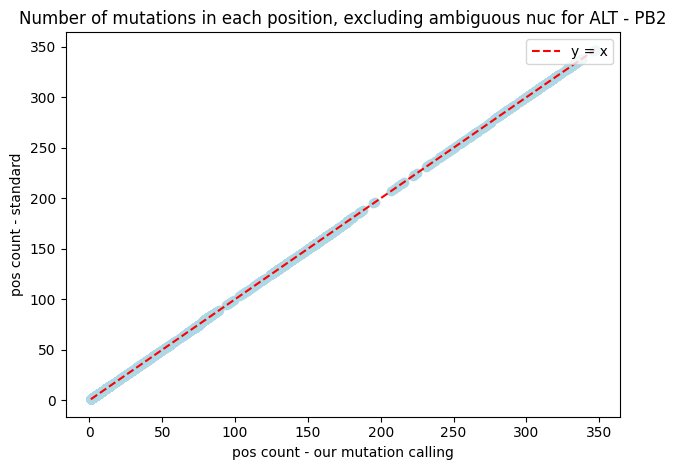

,sra,pos_count_standard,pos_count_manual,gap


In [59]:
common_set = get_common_seqs(pb2_gf_dir+"alignment.fasta", pb2_mm_dir+"alignment.fasta")

pb2_gf, pb2_gf_filtered = process(pb2_gf_dir+"mutations.tsv", common_set)
pb2_mm, pb2_mm_filtered = process(pb2_mm_dir+"mutations.tsv", common_set)

print(round(len(pb2_mm_filtered)/len(pb2_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt(pb2_gf_filtered, pb2_mm_filtered, "PB2")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)


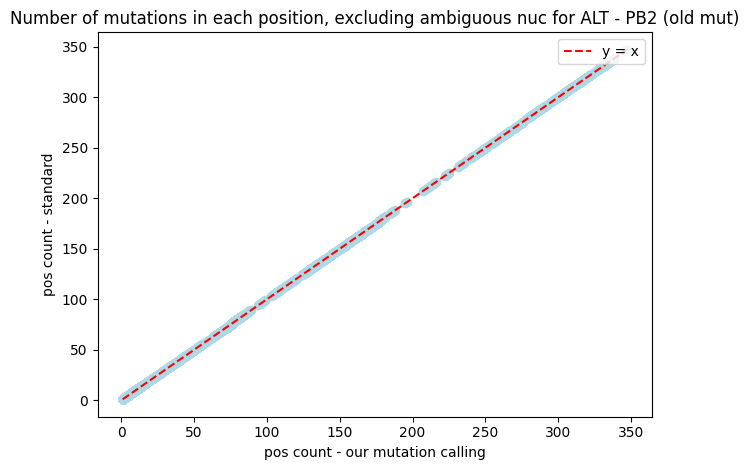

,sra,pos_count_standard,pos_count_manual,gap
324,SRR24839382,332,331,-1
955,SRR24843066,267,266,-1


In [65]:
pb2_old, _ = process(pb2_old_dir+"mutations.tsv", None)
pb2_mm, _ = process(pb2_mm_dir+"mutations.tsv", None)
pb2_mm["sra"] = pb2_mm["sra"].apply(lambda x: x.split('_')[1])

pos_mismatch = corr_plt(pb2_old, pb2_mm, "PB2 (old mut)")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)


In [58]:
tmp1 = (pb2_gf[~pb2_gf["alt"].isin(ambiguous_nuc)]
        .drop_duplicates(subset=["sra", "pos", "ref", "alt"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)
tmp2 = (pb2_mm[~pb2_mm["alt"].isin(ambiguous_nuc)]
        .drop_duplicates(subset=["sra", "pos", "ref", "alt"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)

tmp1.equals(tmp2)

True

97.0 % sequences are identical.


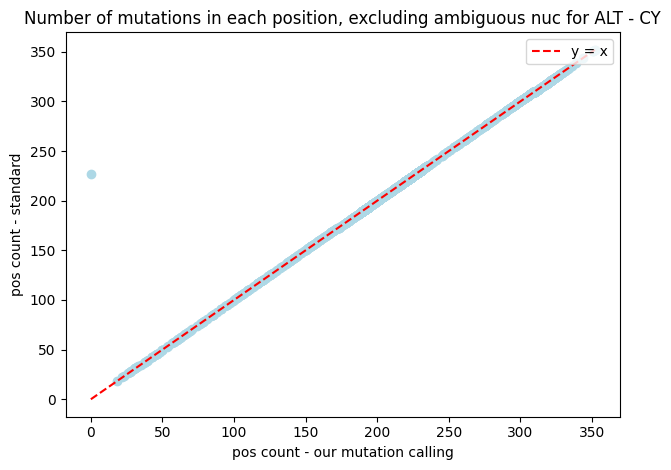

,sra,pos_count_standard,pos_count_manual,gap
1493,SRR28752635,227,0.0,-227.0


In [66]:
common_set = get_common_seqs(cy_gf_dir+"alignment.fasta", cy_mm_dir+"alignment.fasta")

cy_mm, cy_mm_filtered = process(cy_mm_dir+"CY018884.1_cds_ABM21959.1_1_mutations.tsv", common_set)
cy_mm_filtered["sra"] = cy_mm_filtered["sra"].apply(lambda x: x.split('_')[1])
cy_gf, cy_gf_filtered = process(cy_gf_dir+"mutations.tsv", common_set)
cy_gf_filtered["sra"] = cy_gf_filtered["sra"].apply(lambda x: x.split('_')[1])

print(round(len(cy_mm_filtered)/len(cy_mm), 2)*100, "% sequences are identical.")

pos_mismatch = corr_plt(cy_gf_filtered, cy_mm_filtered, "CY")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch = pos_mismatch.sort_values(by=["gap"], ascending=False)

pos_mismatch

In [ ]:
tmp = pos_mismatch[pos_mismatch["pos_count_standard"] == 0]
tmp = tmp.copy()
tmp.loc[:, "sra_file"] = tmp["sra"].apply(lambda x: x+"_PB2_cns.fa")
unmapped_ls = list(tmp["sra_file"])

In [ ]:
for i in range(len(unmapped_ls)):
    f = list(SeqIO.parse("/home/eleanor124/projects/bjorn_rep/data/PB2-DMS/PB2_samples/"+unmapped_ls[i], "fasta"))
    count = f[0].seq.count('-')+f[0].seq.count('N')
    print(count/len(f[0].seq)*100)

In [20]:
f = list(SeqIO.parse("/home/eleanor124/projects/bjorn_rep/data/PB2-DMS/PB2_samples/SRR33319052_PB2_cns.fa", "fasta"))
count = f[0].seq.count('-')+f[0].seq.count('N')
print(count/len(f[0].seq)*100)

38.728070175438596


In [ ]:
tmp1 = cy_gf.loc[(cy_gf["sra"] == "SRR33319052") & (~cy_gf["alt"].isin(ambiguous_nuc)), :]
tmp2 = cy_mm.loc[(cy_mm["sra"] == "SRR33319052") & (~cy_mm["alt"].isin(ambiguous_nuc)), :]
m = pd.merge(tmp1, tmp2, how="outer", indicator=True, on=["sra", "pos"])
m[m["_merge"]!="both"]

,sra,region_x,pos,ref_x,alt_x,region_y,ref_y,alt_y,_merge
111,SRR33319052,NaN,21,NaN,NaN,PB2,A,G,right_only
112,SRR33319052,NaN,42,NaN,NaN,PB2,C,T,right_only
113,SRR33319052,NaN,60,NaN,NaN,PB2,C,A,right_only
114,SRR33319052,NaN,75,NaN,NaN,PB2,G,T,right_only
115,SRR33319052,NaN,78,NaN,NaN,PB2,T,C,right_only
116,SRR33319052,NaN,81,NaN,NaN,PB2,T,C,right_only
117,SRR33319052,NaN,96,NaN,NaN,PB2,A,G,right_only
118,SRR33319052,NaN,99,NaN,NaN,PB2,A,G,right_only
119,SRR33319052,NaN,435,NaN,NaN,PB2,T,C,right_only
120,SRR33319052,NaN,447,NaN,NaN,PB2,T,G,right_only


In [ ]:
x = 'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAGCTAATAGTAAGTGGAAGAGACGAGCAGTCAATTGCTGAAGCAATAANNNNNNNNNNNNNNNNNNNNNNNGAAGACTGCATGATCAAGGCNNNNNNNNNNNNNNNNNNNNNTGTCAATAGGGCGAACCAGCGGCTGAATCCAATGCATCAACTCTTGAGACACTTCCAAAAGGATGCTAAAGTGCTTTTCCAAAACTGGGGAATTGAATCCATTGACAATGTGATGGGGATGATTGGGATATTGCCCGACATGACCCCAAGCACTGAGANNNNNNNNNNNNGANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTCCAGTACNNNNNNNNNNNNNNNNNNCATCGACCGATTTTTAAGAGTCCGGGACCAANNNNNNAACGTACTATTGTCACCAGAAGAAGTCAGCGAGACACAAGGAACAGAGAAATTNNNNNNNNNNNNNNCGTCATCAATGATGTGGGAGNNNNNNNNNNNNNNNNNNGTGTTGGTCNNNNNNNNNNNNNNGATAATCAGAAACTGGGAAACTGTGAAAATTCAATGGTCACAGGATCCCACAATGCTATATAATAAGATGGAATTCGAGCCATTCCAGTCTCTGGTACCCAAAGCAGCCAGAGGTCAATACAGTGGATTCGTGAGGACACTATTCCAGCAGATGCGAGATGTGCTCGGAACATTTGACACTGTTCAAATAATAAAACTCCTCCCCTTTGCTGCTGCCCCACCAGAACAGAGTAGAATGCAATTCTCCTCCCTGACTGTAAATGTGAGGGGATCAGGAATGAGAATACTGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGGTGCACNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN'
x.count("N")/len(x)